In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
import networkx as nx

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import LocallyLinearEmbedding, TSNE
from umap import UMAP
import pandas as pd
import seaborn as sns

In [2]:

import numpy as np
import sys
sys.path.append("../datasets/")
sys.path.append("../")
import utils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import LocallyLinearEmbedding, TSNE
from umap import UMAP
import seaborn as sns
import pandas as pd
sns.set_style("darkgrid")

# Preprocessing: Experimental Place Cells

In [3]:
# from gvae.model import VAE_loss
from torch.optim import Adam
import torch

In [4]:
from torch.utils.data import Dataset
import os
import pandas as pd
from tqdm import tqdm


class CyclicWalk(Dataset):

    def __init__(self, path, randomize_pairs=True, time_bin=1000000, velocity_threshold=0.1):

        super().__init__()
        self.name = "cyclic-walk"
        self.randomize_pairs = randomize_pairs
        self.velocity_threshold = velocity_threshold
        
        mat = utils.loadmat(path)
        rosdata = mat["x"]["rosdata"]
        enctimes = rosdata["encTimes"]
        velocity = mat["x"]["rosdata"]["vel"]
        encangle = rosdata["encAngle"]
        n_cells = len(mat["x"]["clust"])
                
        times = self.get_times(mat)
        
        # Bin times
        regular_times = np.arange(start=times[0], stop=times[-1], step=time_bin)
        n_times = len(regular_times) - 1
        place_cells = np.zeros((n_times, n_cells))

        for i_cell, cell in tqdm(enumerate(mat["x"]["clust"])):
            # print(f"Processing cell {i_cell}...")
            counts, bins, _ = plt.hist(cell["ts"], bins=regular_times)
            assert sum(bins != regular_times) == 0
            assert len(counts) == n_times
            place_cells[:, i_cell] = counts
            
        # Standardize the Data
        place_cells = place_cells - place_cells.mean(axis=-1, keepdims=True)
        place_cells = place_cells / (np.linalg.norm(place_cells, axis=-1, keepdims=True) + 1e-10)
                
        enc_counts, enc_bins = np.histogram(enctimes, bins=regular_times)
        
        # Bin Position Angles
        angles = []
        cum_count = 0
        for count in enc_counts:
            angles.append(np.mean(encangle[cum_count:cum_count+int(count)]))
            cum_count += int(count)
        assert len(angles) == len(regular_times) -1
        angles = [x % 360 for x in angles]
        angles = torch.tensor([np.deg2rad(x) for x in angles])
        
        # Bin Velocity
        velocities = []
        cum_count = 0
        for count in enc_counts:
            velocities.append(np.mean(velocity[cum_count:cum_count+int(count)]))
            cum_count += int(count)
        assert len(velocities) == len(regular_times) -1
        velocities = torch.tensor(velocities)
        
        vel_idx = abs(velocities) >= velocity_threshold
        place_cells = place_cells[vel_idx]
        angles = angles[vel_idx]
        
        good_idx = np.where(place_cells.max(axis=-1) != 0.0)
        place_cells = place_cells[good_idx]
        angles = angles[good_idx]
        velocities = velocities[good_idx]
        
        if self.randomize_pairs:
            data, data_next, angle_diff = self.construct_dataset_r(place_cells, angles)

        else:
            data, data_next, angle_diff = self.construct_dataset(place_cells, angles)
            
        self.velocity = velocities
        self.dim = data.shape[1]
        self.data = torch.tensor(data)
        self.data_next = torch.tensor(data_next)
        self.angle = torch.tensor(angle_diff)
        self.pos = angles
        
    def get_times(self, mat):
        times = []
        for clust in mat["x"]["clust"]:
            times.extend(clust["ts"])

        times = sorted(times)
        n_times = len(times)
        # print(f"Number of times before deleting duplicates: {n_times}.")
        aux = []
        for time in times:
            if time not in aux:
                aux.append(time)
        n_times = len(aux)
        # print(f"Number of times after deleting duplicates: {n_times}.")
        times = aux
        times = np.array(times)
        return times
    
    def construct_dataset(self, time_series, angles):
        data = time_series[:-1]
        angle_t = angles[:-1]
        data_t1 = time_series[1:]
        angle_t1 = angles[1:]
        angle_diff = []
        for i, dt in enumerate(data):
            diff = (angle_t1[i] - angle_t[i]) % (2 * np.pi)
            angle_diff.append(diff)
        return data, data_t1, angle_diff
    
    def construct_dataset_r(self, time_series, angles):
        data = time_series
        angle_t = angles
        idx = np.arange(len(data))
        np.random.shuffle(idx)
        # idx = torch.tensor(idx)
        data_t1 = time_series[idx]
        angle_t1 = angles[idx]
        angle_diff = []
        for i, dt in enumerate(data):
            diff = (angle_t1[i] - angle_t[i]) % (2 * np.pi)
            angle_diff.append(diff)
        return data, data_t1, angle_diff

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.data_next[idx]
        angle = self.angle[idx]
        return x, y, angle

    def __len__(self):
        return len(self.data)

In [66]:
from collections import OrderedDict
import torch.nn.functional as F

class VAE(torch.nn.Module):
    def __init__(
        self,
        input_dim=256,
        latent_dim=32,
        encoder_dims=[64, 64, 32],
        weight_init=torch.nn.init.xavier_uniform_,
        device="cpu",
    ):
        """
        Variational Autoencoder (VAE)

        """
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.encoder_dims = encoder_dims
        self.decoder_dims = encoder_dims[::-1]
        self.weight_init = weight_init
        self.device = device
        self.build()

    def build(self):
        self.generate_encoder()
        self.generate_decoder()
        
    def generate_module(self, layer_dims, out_fn=None):
        layers = OrderedDict()

        for i in range(len(layer_dims) - 1):
            layers["fc_{}".format(i)] = torch.nn.Linear(
                layer_dims[i], layer_dims[i + 1], bias=True
            )
            self.weight_init(layers["fc_{}".format(i)].weight)
            if i < len(layer_dims) - 2:
                layers["nl_{}".format(i)] = torch.nn.ReLU()
            if i == len(layer_dims) - 2 and out_fn is not None:
                layers["out_{}".format(i)] = out_fn
            else:
                continue

        module = torch.nn.Sequential(layers)
        return module

    def generate_encoder(self):
        encoder_dims = [self.input_dim] + self.encoder_dims
        self.encoder = self.generate_module(encoder_dims, out_fn=torch.nn.ReLU())
        self.mu_z = torch.nn.Linear(self.encoder_dims[-1], self.latent_dim)
        self.var_z = torch.nn.Linear(self.encoder_dims[-1], self.latent_dim)

    def generate_decoder(self):
        decoder_dims = [self.latent_dim] + self.decoder_dims
        self.decoder = self.generate_module(decoder_dims, out_fn=None)
        self.mu_x = torch.nn.Linear(self.decoder_dims[-1], self.input_dim)
        self.var_x = torch.nn.Linear(self.decoder_dims[-1], self.input_dim)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std    
        return z

    def sample(self, n_samples):
        z = torch.randn(n_samples, self.latent_dim)
        samples = self.decoder(z)
        return samples

    def to_latent(self, X):
        mu, log_var = self.encode(X)
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var
    
    def encode(self, X):
        latent_rep = self.encoder(X)
        mu_z = self.mu_z(latent_rep)
        log_var_z = self.var_z(latent_rep)
        return mu_z, log_var_z
    
    def decode(self, z):
        out = self.decoder(z)
        mu_x = self.mu_x(out)
        log_var_x = self.var_x(out)
        return mu_x, log_var_x

    def forward(self, x):
        z, mu_z, log_var_z = self.to_latent(x)
        mu_x, log_var_x = self.decode(z)
        return mu_x, log_var_x, mu_z, log_var_z
            
#     def decode(self, z):
#         """Decode latent variable z into data.
#         Parameters
#         ----------
#         z : array-like, shape=[batch_size, latent_dim]
#             Input to the decoder.
#         Returns
#         -------
#         _ : array-like, shape=[batch_size, data_dim]
#             Reconstructed data corresponding to z.
#         """
#         h3 = F.relu(self.fc3(z))
#         h4 = F.relu(self.fc4(h3))
#         if self.gen_likelihood_type == "Gaussian":
#             x_mu = self.fc_x_mu(h4)
#             #adding hidden layer to x_logvar
#             h_x_logvar = self.fc_x_logvar1(h4)
#             x_logvar = self.fc_x_logvar2(h_x_logvar)
#             gen_likelihood_params = x_mu, x_logvar
#         elif self.gen_likelihood_type == "Poisson":
#             x_lambda = self.fc_x_lambda(h4)
#             gen_likelihood_params = x_lambda
        
#         return gen_likelihood_params
    
    
def elbo(x, x_mu, x_logvar, z_mu, z_logvar, beta=1.0):
    """Compute VAE loss function.
    The VAE loss is defined as:
    = reconstruction loss + Kl divergence
    over all elements and batch
    Notes
    -----
    see Appendix B from VAE paper:
    Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    https://arxiv.org/abs/1312.6114
    0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    Parameters
    ----------
    x : array-like, shape=[batch_size, data_dim]
        Input data.
    gen_likelihood_params : tuple
        Distributional parameters of generative model. ((e.g.), (x_mu,x_logvar) for Gaussian.
    posterior_params : tuple
        Distributional parameters of approximate posterior. ((e.g.), (z_mu,z_logvar) for Gaussian.
    beta : float
        multiplicative factor in front of Kld term in loss, should help with 
        disentangling latent space. Classic VAE has beta = 1. See beta-VAE (Higgins, et al.)
    Returns
    -------
    _ : array-like, shape=[batch_size,]
        Loss function on each batch element.
    """
    z_var = torch.exp(z_logvar)
    kld = -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_var)
    x_var = torch.exp(x_logvar)
    # manually setting x_var = 0.001
#     x_var = torch.zeros(x_var.shape) + 1e-3
#     recon_loss = torch.sum(0.5 * torch.log(x_var) + 0.5 * torch.div((x - x_mu).pow(2), x_var)) # + constant
    recon_loss = torch.sum(0.5 * x_logvar + 0.5 * torch.div((x - x_mu).pow(2), torch.exp(x_logvar))) # + constant
    return recon_loss + beta * kld

In [72]:
from torch_tools.trainer import Trainer


class VAETrainer(Trainer):
    def __init__(
        self,
        model,
        loss,
        optimizer,
        logger=None,
        scheduler=None,
        regularizer=None,
        normalizer=None,
    ):
        super().__init__(model,
                         loss,
                         optimizer,
                         logger,
                         scheduler,
                         regularizer,
                         normalizer)

    def step(self, data_loader, grad=True):
        """Compute a single step of training.
        This example is a minimal implementation of the `step` function
        for a classification problem with a simple regularization on
        the model parameters.
        Parameters
        ----------
        data_loader : torch.utils.data.dataloader.DataLoader
        grad : boolean
            required argument to switch between training and evaluation
        Returns
        -------
        log_dict : dictionary with losses to be logged by the trainer/logger
            format - {'total_loss': total_loss, 'l1_penalty': l1_penalty, ...}
            Your dictionary must contain a key called `total_loss`
        """
        log_dict = {"loss": 0, "reg_loss": 0, "total_loss": 0}
        for i, (x, _, _) in enumerate(data_loader):
            total_loss = 0
            x = x.to(self.model.device)
            if grad:
                self.optimizer.zero_grad()
                mu_x, log_var_x, mu_z, log_var_z = self.model.forward(x)
            else:
                with torch.no_grad():
                    mu_x, log_var_x, mu_z, log_var_z = self.model.forward(x)
            
            # Compute loss term without regularization terms
            loss = self.loss(x, mu_x, log_var_x, mu_z, log_var_z, beta=1.0)
            
            log_dict["loss"] += loss 
            total_loss += loss

            # Compute regularization penalty terms (e.g. sparsity, l2 norm, etc.)
            if self.regularizer:
                reg_variable_dict = {
                    "x": x,
                    "xh": xh,
                } | dict(self.model.named_parameters()) # Must use named parameters rather than state_dict to preserve grads

                reg_loss += self.regularizer(reg_variable_dict)
                log_dict["reg_loss"] += reg_loss
                total_loss += reg_loss

            if grad:
                total_loss.backward()
                self.optimizer.step()
                
            if self.normalizer is not None:
                self.normalizer(dict(self.model.named_parameters()))

            log_dict["total_loss"] += total_loss

        # Normalize loss terms for the number of samples/batches in the epoch (optional)
        n_samples = len(data_loader)
        for key in log_dict.keys():
            log_dict[key] /= n_samples

        plot_variable_dict = {"model": self.model}

        return log_dict, plot_variable_dict
    
    
import torch
from torch.nn import functional as F


# def elbo(recon_x, x, mu, logvar, beta=1.0):
#     """Compute VAE loss function.
#     The VAE loss is defined as:
#     = reconstruction loss + Kl divergence
#     over all elements and batch
#     Notes
#     -----
#     see Appendix B from VAE paper:
#     Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#     https://arxiv.org/abs/1312.6114
#     0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#     Parameters
#     ----------
#     recon_x : array-like, shape=[batch_size, data_dim]
#         Reconstructed data corresponding to input data x.
#     x : array-like, shape=[batch_size, data_dim]
#         Input data.
#     mu : array-like, shape=[batch_size, latent_dim]
#         Mean of multivariate Gaussian in latent space.
#     logvar : array-like, shape=[batch_size, latent_dim]
#         Vector representing the diagonal covariance of the
#         multivariate Gaussian in latent space.
#     Returns
#     -------
#     _ : array-like, shape=[batch_size,]
#         Loss function on each batch element.
#     """
#     recon_loss = F.cross_entropy(recon_x, x, reduction="sum")

#     kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#     return (recon_loss + beta * kld) / len(x)

# def VAE_loss(x, x_hat, mu, log_var, kl_weight=0.0):
#     recon_error = F.mse_loss(x_hat, x)
#     kl_divergence = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim=0)
#     L = recon_error + kl_weight * kl_divergence
#     return L

In [68]:
import copy

class TrainValLoader:
    def __init__(self, 
                 batch_size, 
                 fraction_val=0.2,
                 num_workers=0, 
                 seed=0):
        assert (
            fraction_val <= 1.0 and fraction_val >= 0.0
        ), "fraction_val must be a fraction between 0 and 1"

        np.random.seed(seed)

        self.batch_size = batch_size
        self.fraction_val = fraction_val
        self.seed = seed
        self.num_workers = num_workers
        
    def split_data(self, dataset):
        
        if self.fraction_val > 0.0:
            dataset_size = len(dataset)
            indices = list(range(dataset_size))
            split = int(np.floor(self.fraction_val * len(dataset)))

            np.random.shuffle(indices)

            train_indices, val_indices = indices[split:], indices[:split]
            val_dataset = copy.deepcopy(dataset)
            val_dataset.data = val_dataset.data[val_indices]
            val_dataset.data_next = val_dataset.data_next[val_indices]
            val_dataset.angle = val_dataset.angle[val_indices]
            
            train_dataset = copy.deepcopy(dataset)
            train_dataset.data = train_dataset.data[train_indices]
            train_dataset.data_next = train_dataset.data_next[train_indices]
            train_dataset.angle = train_dataset.angle[train_indices]
        
        else:
            val_dataset = None
    
        return train_dataset, val_dataset
    
    def construct_data_loaders(self, train_dataset, val_dataset):
        if val_dataset is not None:
            val = torch.utils.data.DataLoader(
                val_dataset,
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=self.num_workers,
                pin_memory=True
            )
        
        else:
            val = None
            
        train = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )
        
        return train, val         

    def load(self, dataset):
        train_dataset, val_dataset = self.split_data(dataset)
        self.train, self.val = self.construct_data_loaders(train_dataset, val_dataset)

In [52]:
path = "../data/expt34.mat"
time_bin = 1000000
dataset = CyclicWalk(path=path, randomize_pairs=True, time_bin=time_bin, velocity_threshold=0.3)

KeyboardInterrupt: 

In [34]:
dataset.data = dataset.data.float()
dataset.data_next = dataset.data_next.float()
dataset.angle = dataset.angle.float()

In [13]:
dataset.data.float().dtype

torch.float32

In [35]:
# dataset.data = dataset.data - dataset.data.mean(axis=-1, keepdim=True)
# dataset.data = dataset.data / (dataset.data.std(axis=-1, keepdim=True) + 1e-10)
# dataset.data_next = dataset.data_next - dataset.data_next.mean(axis=-1, keepdim=True)
# dataset.data_next = dataset.data_next / (dataset.data_next.std(axis=-1, keepdim=True) + 1e-10)

In [36]:
# dataset.data = dataset.data / (torch.norm(dataset.data, dim=-1, keepdim=True) + 1e-10)
# dataset.data_next = dataset.data_next / (torch.norm(dataset.data_next, dim=-1, keepdim=True) + 1e-10)

In [37]:
# dataset.data = dataset.data[good_idx]
# dataset.data_next = dataset.data_next[good_idx]
# dataset.angle = dataset.angle[good_idx]

In [38]:
# dataset.data = dataset.data - dataset.data.mean(axis=0, keepdim=True)
# dataset.data = dataset.data / (dataset.data.std(axis=0, keepdim=True) + 1e-10)
# dataset.data_next = dataset.data_next - dataset.data_next.mean(axis=0, keepdim=True)
# dataset.data_next = dataset.data_next / (dataset.data_next.std(axis=0, keepdim=True) + 1e-10)

In [39]:
dataset.data.mean(axis=-1)

tensor([ 1.4901e-09,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         1.4901e-09, -1.4901e-09])

In [40]:
dataset.data.norm(dim=-1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])

In [41]:
dataset.angle

tensor([6.2599, 1.7350, 3.8316,  ..., 3.8188, 4.0698, 5.9853])

In [42]:
dataset.angle

tensor([6.2599, 1.7350, 3.8316,  ..., 3.8188, 4.0698, 5.9853])

In [263]:
model = VAE(input_dim=40,
             latent_dim=2, 
             encoder_dims=[400, 400, 100, 50, 40, 30, 20, 5])

optimizer = Adam(params=model.parameters(), lr=.001)

In [264]:
# from torch_tools.data import TrainValLoader

data_loader = TrainValLoader(batch_size=40, fraction_val=0.2)
data_loader.load(dataset)

In [265]:
trainer = VAETrainer(model=model, loss=elbo, optimizer=optimizer)
trainer.train(data_loader, 500)

Epoch 0 ||  N Examples 0 || Train Total Loss -1133.67908 || Validation Total Loss -2063.24707
Epoch 1 ||  N Examples 890 || Train Total Loss -2239.34961 || Validation Total Loss -2223.43921
Epoch 2 ||  N Examples 1780 || Train Total Loss -2399.38379 || Validation Total Loss -2294.67285
Epoch 3 ||  N Examples 2670 || Train Total Loss -2509.62817 || Validation Total Loss -2431.25269
Epoch 4 ||  N Examples 3560 || Train Total Loss -2558.74927 || Validation Total Loss -2372.46167
Epoch 5 ||  N Examples 4450 || Train Total Loss -2538.56274 || Validation Total Loss -2405.09546
Epoch 6 ||  N Examples 5340 || Train Total Loss -2554.17651 || Validation Total Loss -2376.69409
Epoch 7 ||  N Examples 6230 || Train Total Loss -2542.03662 || Validation Total Loss -2404.65747
Epoch 8 ||  N Examples 7120 || Train Total Loss -2568.79541 || Validation Total Loss -2420.91602
Epoch 9 ||  N Examples 8010 || Train Total Loss -2576.75073 || Validation Total Loss -2431.86377
Epoch 10 ||  N Examples 8900 || Tr

In [247]:

samples = model.sample(150).detach().numpy()

In [248]:
samples.shape

(150, 400)

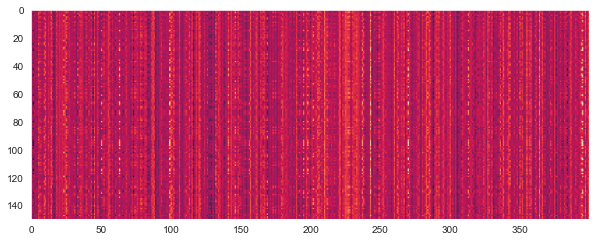

In [249]:
sns.set_style("dark")
plt.figure(figsize=(10, 10))
plt.imshow(samples)

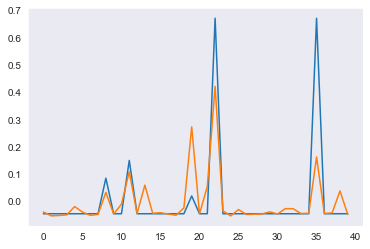

In [256]:
idx = np.random.randint(len(dataset.data))
x = dataset.data[idx]
angle = dataset.angle[0]
x_hat, x_hat_, _, _ = model.forward(x.unsqueeze(0))
x_hat = x_hat.detach()
x_hat_ = x_hat_.detach()

plt.plot(x)
plt.plot(x_hat.squeeze())

In [257]:
z, mu, sigma = model.to_latent(dataset.data)
z = z.detach()
mu = mu.detach()
sigma = sigma.detach()

In [258]:
# z1 = model.act(z, dataset.angle)

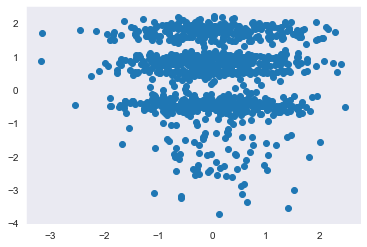

In [259]:
plt.scatter(z[:, 0], z[:, 1])

In [260]:
df = pd.DataFrame({"z0": z[:, 0], "z1": z[:, 1], "pos": dataset.pos})

In [261]:
# df2 = pd.DataFrame({"z0": z1[:, 0], "z1": z1[:, 1], "pos": (dataset.pos + dataset.angle) % (2 * np.pi)})

<AxesSubplot:xlabel='z0', ylabel='z1'>

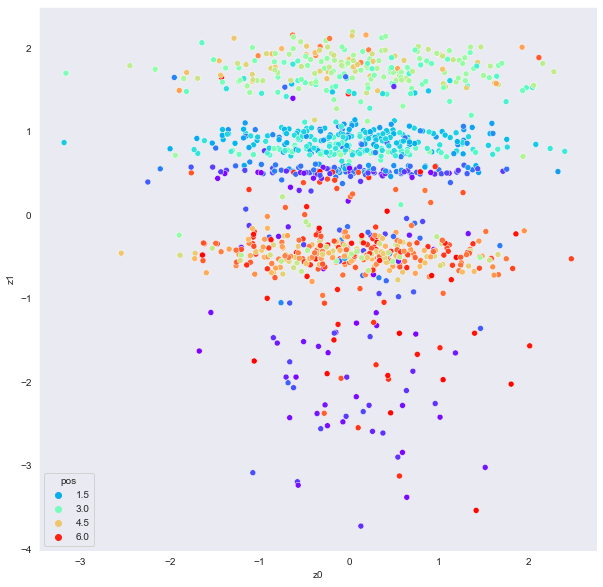

In [262]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="z0", y="z1", hue="pos", data=df, palette="rainbow")

<AxesSubplot:xlabel='z0', ylabel='z1'>

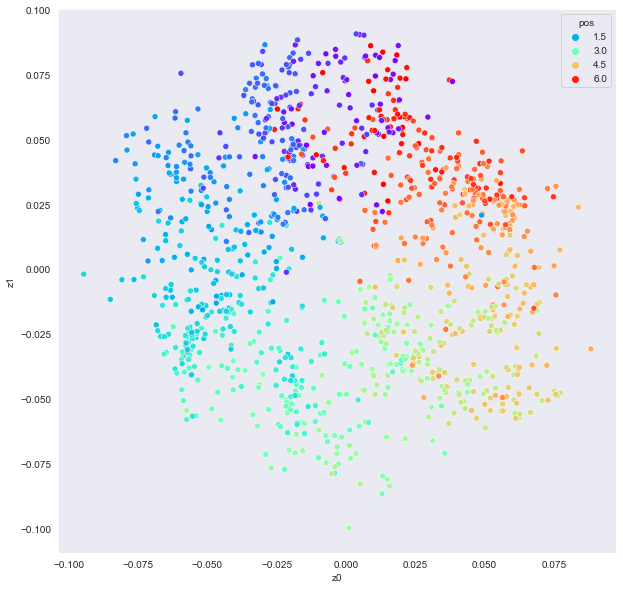

In [192]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="z0", y="z1", hue="pos", data=df, palette="rainbow")

<AxesSubplot:xlabel='z0', ylabel='z1'>

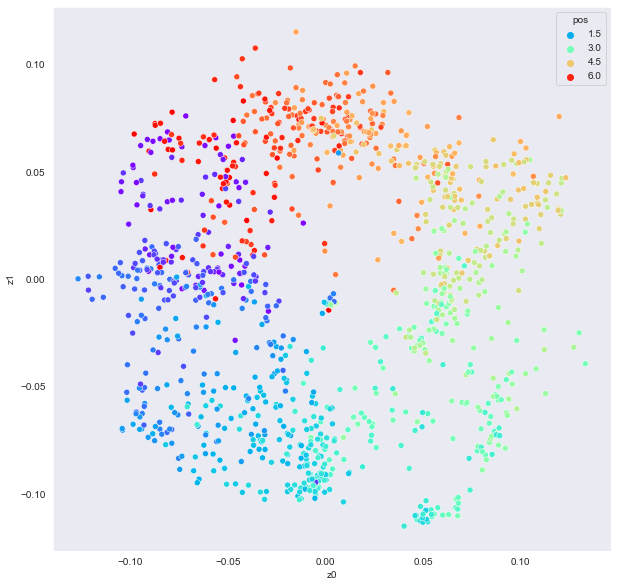

In [139]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="z0", y="z1", hue="pos", data=df, palette="rainbow")

<AxesSubplot:xlabel='z0', ylabel='z1'>

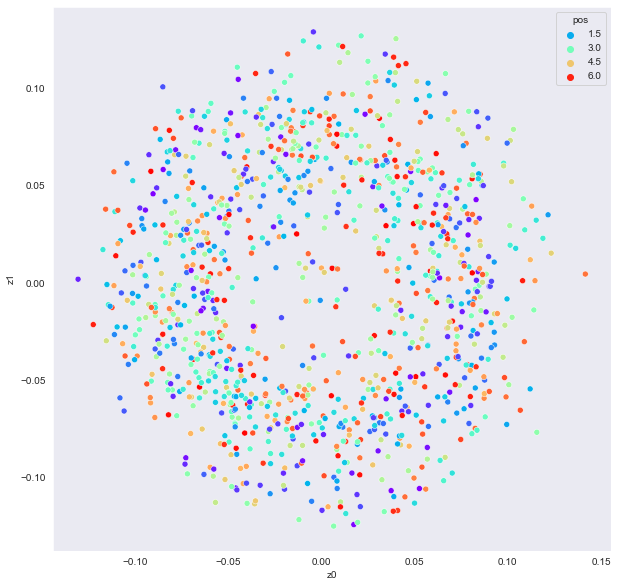

In [146]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="z0", y="z1", hue="pos", data=df2, palette="rainbow")

<AxesSubplot:xlabel='z0', ylabel='z1'>

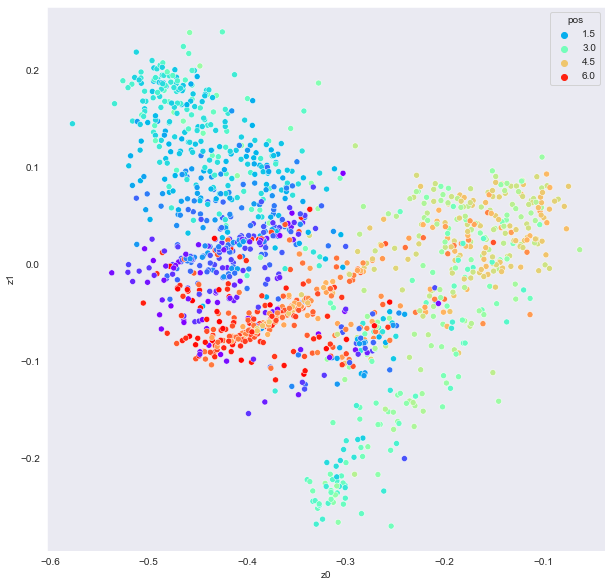

In [442]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="z0", y="z1", hue="pos", data=df, palette="rainbow")